In [1]:
# from functools import partial
from pathlib import Path
# from typing import Optional, Tuple
# import cv2
# import fire
import numpy as np
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from PIL import Image
from scipy.sparse.linalg import eigsh
# from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
# from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
import extract_utils as utils
from torch.utils.data import Dataset, DataLoader
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from torch import nn
import torchvision
from scipy.ndimage import affine_transform
from numpy import asarray
import cv2 as cv
import matplotlib.pyplot as plt

## Extract Eigen Vectors

In [2]:
# features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD_1/features/dino_vits16"
# images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/images"
# features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/feats_vis_feature_affinity/"

# images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/ground_truth_mask"
# features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/"

# images_root='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/srg/crf/laplacian_dino_vits16'
# features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_srg/"
#
# images_root='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/srg_dot1PCA64linearpredlinear_dssubmax_pred2_run3/crf/laplacian_dino_vits16'
# features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_ours/"



In [3]:
# images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/VOC2012/images/trainval/JPEGImages"
# # features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD_1/features/dino_vits16"
# features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/VOC2012/features/dino_vits16"
# output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/VOC2012/eigs_test/laplacian"
filename='0079_resized'
output_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new"
which_matrix= 'laplacian'
which_color_matrix= 'knn'
which_features= 'k'
normalize=True
threshold_at_zero=True
lapnorm= True
K= 5
image_downsample_factor = None
image_color_lambda = 1.0
multiprocessing = 0
batch_size=2
epochs=10

## Incorporating SimSiam

In [4]:
# Define a custom dataset class
class Feature_Dataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __getitem__(self, index):
        return self.features[index]

    def __len__(self):
        return len(self.features)

## Ours Mask

In [5]:
images_root='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/srg_dot1PCA64linearpredlinear_dssubmax_pred2_run3/crf/laplacian_dino_vits16'
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_ours/"
pca_comp=64
pca = PCA(n_components=pca_comp)
utils.make_output_dir(output_dir)
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))

features_file = features_dir + filename +'.pth'
print(features_file)
 # Load
data_dict = torch.load(features_file, map_location='cpu')
print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
# print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
image_id = data_dict['file'][:-4]
print(image_id)
# Load
output_file = str(Path(output_dir) / f'{image_id}.pth')
if Path(output_file).is_file():
    print(f'Skipping existing file {str(output_file)}')
    # break
    # return  # skip because already generated

# Load affinity matrix
feats = data_dict[which_features].squeeze().cuda()
print("Without normalizing, Features Shape outside laplacian is",feats.shape)
if normalize:
    feats = F.normalize(feats, p=2, dim=-1)
print("After normalization, Features Shape outside laplacian ",feats.shape)
# print("which_matrix=", which_matrix)
# Eigenvectors of affinity matrix
if which_matrix == 'affinity_torch':
    W = feats @ feats.T
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
        # print("W shape=", W.shape)
    eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
    eigenvalues = eigenvalues.cpu()
    eigenvectors = eigenvectors.cpu()
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity_svd':
    USV = torch.linalg.svd(feats, full_matrices=False)
    eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
    eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
    print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity':
    # print("Without normalizing, Features Shape is",feats.shape)
    W = (feats @ feats.T)
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
    W = W.cpu().numpy()
    # print("W shape=", W.shape)
    eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
    eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of matting laplacian matrix
elif which_matrix in ['matting_laplacian', 'laplacian']:

    # Get sizes
    B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
    if image_downsample_factor is None:
        image_downsample_factor = P
    H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

    # Upscale features to match the resolution
    if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
        feats = F.interpolate(
            feats.T.reshape(1, -1, H_patch, W_patch),
            size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
        ).reshape(-1, H_pad_lr * W_pad_lr).T

    ### Feature affinities
    print("Without normalizing, Features Shape insiade laplacian is",feats.shape)

    W_feat_ds_oursmask = (feats @ feats.T)
    print("shape of W_feat_ds_oursmask", W_feat_ds_oursmask.shape)
    max_wfeatds=torch.max(W_feat_ds_oursmask).item()
    alpha=3
    print("Before Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_oursmask, 0.))
    print("positive values=", count_positive)
    W_feat_ds_oursmask_sum = torch.sum(W_feat_ds_oursmask)
    print("W_feat_ds_oursmask_sum=", W_feat_ds_oursmask_sum)
    W_feat_ds_oursmask_mean = torch.mean(W_feat_ds_oursmask)
    print("Mean of W_feat_ds_oursmask", W_feat_ds_oursmask_mean)
    W_feat_ds_oursmask_median = torch.median(W_feat_ds_oursmask)
    print("Median of W_feat_ds_oursmask", W_feat_ds_oursmask_median)
    W_feat_ds_oursmask_std = torch.std(W_feat_ds_oursmask)
    print("Standard Deviation of W_feat_ds_oursmask", W_feat_ds_oursmask_std)
    W_feat_ds_oursmask_max = torch.max(W_feat_ds_oursmask)
    print("Maximum of W_feat_ds_oursmask", W_feat_ds_oursmask_max)
    W_feat_ds_oursmask_min = torch.min(W_feat_ds_oursmask)
    print("Minimum of W_feat_ds_oursmask", W_feat_ds_oursmask_min)
    print("Factor value", (max_wfeatds / alpha))

    W_feat_ds_oursmask = W_feat_ds_oursmask - (max_wfeatds / alpha)

    print("After Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_oursmask, 0.))
    print("positive values=", count_positive)
    W_feat_ds_oursmask_sum = torch.sum(W_feat_ds_oursmask)
    print("W_feat_ds_oursmask_sum=", W_feat_ds_oursmask_sum)
    W_feat_ds_oursmask_mean = torch.mean(W_feat_ds_oursmask)
    print("Mean of W_feat_ds_oursmask", W_feat_ds_oursmask_mean)
    W_feat_ds_oursmask_median = torch.median(W_feat_ds_oursmask)
    print("Median of W_feat_ds_oursmask", W_feat_ds_oursmask_median)
    W_feat_ds_oursmask_std = torch.std(W_feat_ds_oursmask)
    print("Standard Deviation of W_feat", W_feat_ds_oursmask_std)
    W_feat_ds_oursmask_max = torch.max(W_feat_ds_oursmask)
    print("Maximum of W_feat_ds_oursmask", W_feat_ds_oursmask_max)
    W_feat_ds_oursmask_min = torch.min(W_feat_ds_oursmask)
    print("Minimum of W_feat_ds_oursmask", W_feat_ds_oursmask_min)
    proj_layer=nn.Linear(pca_comp,pca_comp).cuda()
    pred_layer=nn.Linear(pca_comp,pca_comp).cuda()
    x0=feats
    x0_arr=x0.cpu()
    # print(x0_arr.shape)
    z0_arr= pca.fit_transform(x0_arr)

    # Define the affine transformation parameters
    scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
    translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
    rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
    shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions

    # Define the affine matrix
    affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
                              [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
                              [0, 0, 1]])
    z1_arr=affine_transform(z0_arr, affine_matrix)
#         z1_arr=pca.fit_transform(z1_arr)
    z0 = torch.from_numpy(z0_arr).float()
    z1 = torch.from_numpy(z1_arr).float()

    # feat_list.append(feats)
    feat_dataset_z0 = Feature_Dataset(z0)
    if feats.shape[0]%2==0:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)

    feat_dataset_z1 = Feature_Dataset(z1)
    if feats.shape[0]%2==0:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    criterion = NegativeCosineSimilarity()
    proj_optimizer = torch.optim.SGD(proj_layer.parameters(), lr=0.06)
    pred_optimizer = torch.optim.SGD(pred_layer.parameters(), lr=0.06)
    print("Starting Training")
    for epoch in range(epochs):
        total_loss = 0
        for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
            z0_new = z0_new.to(device)
            z1_new = z1_new.to(device)
            z0_new=proj_layer(z0_new)
            z1_new=proj_layer(z1_new)
#             print("z0_new.shape", z0_new.shape)
#             print("z1_new.shape", z1_new.shape)
            p0=pred_layer(z0_new)
            p1=pred_layer(z1_new)
#             print("p0.shape", p0.shape)
#             print("p1.shape", p1.shape)

            z0_new=z0_new.detach()
            z1_new=z1_new.detach()
            loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
            total_loss += loss.detach()
            loss.backward()
            proj_optimizer.step()
            pred_optimizer.step()
            proj_optimizer.zero_grad()
            pred_optimizer.zero_grad()
        avg_loss = total_loss / len(features_dataloader_z0)
        print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    # z0_projected=proj_layer(z0.to(device))
    projected_feature=pred_layer(z0.to(device))
    print(projected_feature.shape)
    W_feat_siam_oursmask=torch.matmul(projected_feature, projected_feature.t())
    # max_wfeatsiam=torch.max(W_feat_siam_oursmask).item()
    # alpha=3
    # W_feat_siam_oursmask = W_feat_siam_oursmask - (max_wfeatsiam / alpha)
    # W_feat_siam_oursmask=torch.matmul(projected_feature[0], projected_feature[0].t())
    W_feat_oursmask=W_feat_ds_oursmask + 0.1*W_feat_siam_oursmask
    print("W_feat_siam_oursmask.shape=", W_feat_siam_oursmask.shape)
    print("W_feat_ds_oursmask.shape=", W_feat_ds_oursmask.shape)
    print("W_feat_oursmask.shape=", W_feat_oursmask.shape)
    if threshold_at_zero:
        W_feat_oursmask = (W_feat_oursmask * (W_feat_oursmask > 0))
    W_feat_oursmask = W_feat_oursmask / W_feat_oursmask.max()  # NOTE: If features are normalized, this naturally does nothing
    W_feat_oursmask = W_feat_oursmask.detach().cpu().numpy()
    W_feat_ds_oursmask = W_feat_ds_oursmask.detach().cpu().numpy()
    W_feat_siam_oursmask = W_feat_siam_oursmask.detach().cpu().numpy()
    # print("W_feat_oursmask shape=",W_feat_oursmask.shape)

    ### Color affinities
    # If we are fusing with color affinites, then load the image and compute
    W_color=0
    # Combine
    W_comb = W_feat_oursmask + W_color * image_color_lambda  # combination
    D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
    # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
    if lapnorm:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
    else:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
    eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
# Sign ambiguity
for k in range(eigenvectors.shape[0]):
    if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
        eigenvectors[k] = 0 - eigenvectors[k]

# Save dict
output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
torch.save(output_dict, output_file)

Output dir: /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new
/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_ours/0079_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0079_resized
Without normalizing, Features Shape outside laplacian is torch.Size([1024, 384])
After normalization, Features Shape outside laplacian  torch.Size([1024, 384])
Without normalizing, Features Shape insiade laplacian is torch.Size([1024, 384])
shape of W_feat_ds_oursmask torch.Size([1024, 1024])
Before Subtraction
positive values= tensor(948938, device='cuda:0')
W_feat_ds_oursmask_sum= tensor(712737.3750, device='cuda:0')
Mean of W_feat_ds_oursmask tensor(0.6797, device='cuda:0')
Median of W_feat_ds_oursmask tensor(0.8946, device='cuda:0')
Standard Deviation of W_feat_ds_oursmask tensor(0.3871, device='cuda:0')
Maximum

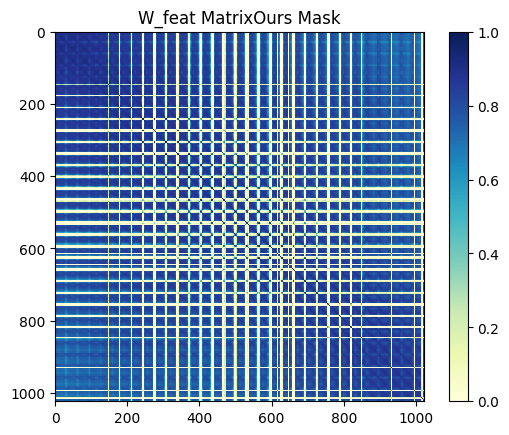

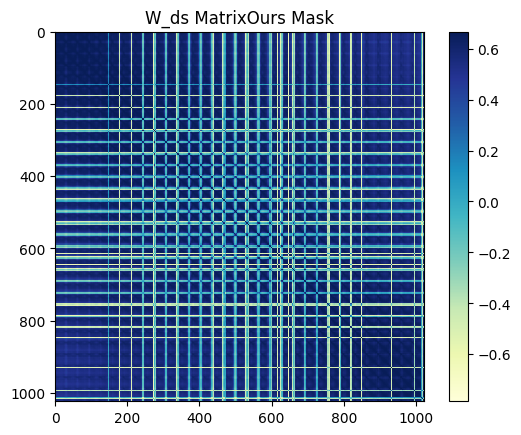

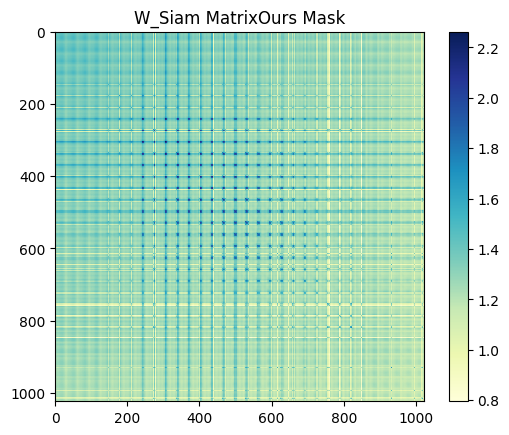

In [6]:
type='Ours Mask'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_oursmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_oursmask.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()



feat='W_ds Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_ds_oursmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_ds_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()

import matplotlib.pyplot as plt


feat='W_Siam Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_siam_oursmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_siam_oursmask.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


## Deep Spectral Mask

In [7]:
images_root='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/srg/crf/laplacian_dino_vits16'
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_srg/"
pca_comp=64
pca = PCA(n_components=pca_comp)
utils.make_output_dir(output_dir)
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))

features_file = features_dir + filename + '.pth'
print(features_file)
 # Load
data_dict = torch.load(features_file, map_location='cpu')
print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
# print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
image_id = data_dict['file'][:-4]
print(image_id)
# Load
output_file = str(Path(output_dir) / f'{image_id}.pth')
if Path(output_file).is_file():
    print(f'Skipping existing file {str(output_file)}')
    # break
    # return  # skip because already generated

# Load affinity matrix
feats = data_dict[which_features].squeeze().cuda()
print("Without normalizing, Features Shape outside laplacian is",feats.shape)
if normalize:
    feats = F.normalize(feats, p=2, dim=-1)
print("After normalization, Features Shape outside laplacian ",feats.shape)
# print("which_matrix=", which_matrix)
# Eigenvectors of affinity matrix
if which_matrix == 'affinity_torch':
    W = feats @ feats.T
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
        # print("W shape=", W.shape)
    eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
    eigenvalues = eigenvalues.cpu()
    eigenvectors = eigenvectors.cpu()
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity_svd':
    USV = torch.linalg.svd(feats, full_matrices=False)
    eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
    eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
    print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity':
    # print("Without normalizing, Features Shape is",feats.shape)
    W = (feats @ feats.T)
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
    W = W.cpu().numpy()
    # print("W shape=", W.shape)
    eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
    eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of matting laplacian matrix
elif which_matrix in ['matting_laplacian', 'laplacian']:

    # Get sizes
    B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
    if image_downsample_factor is None:
        image_downsample_factor = P
    H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

    # Upscale features to match the resolution
    if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
        feats = F.interpolate(
            feats.T.reshape(1, -1, H_patch, W_patch),
            size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
        ).reshape(-1, H_pad_lr * W_pad_lr).T

    ### Feature affinities
    print("Without normalizing, Features Shape insiade laplacian is",feats.shape)

    W_feat_ds_srgmask = (feats @ feats.T)
    print("shape of W_feat_ds_srgmask", W_feat_ds_srgmask.shape)
    max_wfeatds=torch.max(W_feat_ds_srgmask).item()
    alpha=3
    print("Before Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_srgmask, 0.))
    print("positive values=", count_positive)
    W_feat_ds_srgmask_sum = torch.sum(W_feat_ds_srgmask)
    print("W_feat_ds_srgmask_sum=", W_feat_ds_srgmask_sum)
    W_feat_ds_srgmask_mean = torch.mean(W_feat_ds_srgmask)
    print("Mean of W_feat_ds_srgmask", W_feat_ds_srgmask_mean)
    W_feat_ds_srgmask_median = torch.median(W_feat_ds_srgmask)
    print("Median of W_feat_ds_srgmask", W_feat_ds_srgmask_median)
    W_feat_ds_srgmask_std = torch.std(W_feat_ds_srgmask)
    print("Standard Deviation of W_feat_ds_srgmask", W_feat_ds_srgmask_std)
    W_feat_ds_srgmask_max = torch.max(W_feat_ds_srgmask)
    print("Maximum of W_feat_ds_srgmask", W_feat_ds_srgmask_max)
    W_feat_ds_srgmask_min = torch.min(W_feat_ds_srgmask)
    print("Minimum of W_feat_ds_srgmask", W_feat_ds_srgmask_min)
    print("Factor value", (max_wfeatds / alpha))

    W_feat_ds_srgmask = W_feat_ds_srgmask - (max_wfeatds / alpha)

    print("After Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_srgmask, 0.))
    print("positive values=", count_positive)
    W_feat_ds_srgmask_sum = torch.sum(W_feat_ds_srgmask)
    print("W_feat_ds_srgmask_sum=", W_feat_ds_srgmask_sum)
    W_feat_ds_srgmask_mean = torch.mean(W_feat_ds_srgmask)
    print("Mean of W_feat_ds_srgmask", W_feat_ds_srgmask_mean)
    W_feat_ds_srgmask_median = torch.median(W_feat_ds_srgmask)
    print("Median of W_feat_ds_srgmask", W_feat_ds_srgmask_median)
    W_feat_ds_srgmask_std = torch.std(W_feat_ds_srgmask)
    print("Standard Deviation of W_feat", W_feat_ds_srgmask_std)
    W_feat_ds_srgmask_max = torch.max(W_feat_ds_srgmask)
    print("Maximum of W_feat_ds_srgmask", W_feat_ds_srgmask_max)
    W_feat_ds_srgmask_min = torch.min(W_feat_ds_srgmask)
    print("Minimum of W_feat_ds_srgmask", W_feat_ds_srgmask_min)
    proj_layer=nn.Linear(pca_comp,pca_comp).cuda()
    pred_layer=nn.Linear(pca_comp,pca_comp).cuda()
    x0=feats
    x0_arr=x0.cpu()
    # print(x0_arr.shape)
    z0_arr= pca.fit_transform(x0_arr)

    # Define the affine transformation parameters
    scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
    translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
    rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
    shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions

    # Define the affine matrix
    affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
                              [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
                              [0, 0, 1]])
    z1_arr=affine_transform(z0_arr, affine_matrix)
#         z1_arr=pca.fit_transform(z1_arr)
    z0 = torch.from_numpy(z0_arr).float()
    z1 = torch.from_numpy(z1_arr).float()

    # feat_list.append(feats)
    feat_dataset_z0 = Feature_Dataset(z0)
    if feats.shape[0]%2==0:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)

    feat_dataset_z1 = Feature_Dataset(z1)
    if feats.shape[0]%2==0:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    criterion = NegativeCosineSimilarity()
    proj_optimizer = torch.optim.SGD(proj_layer.parameters(), lr=0.06)
    pred_optimizer = torch.optim.SGD(pred_layer.parameters(), lr=0.06)
    print("Starting Training")
    for epoch in range(epochs):
        total_loss = 0
        for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
            z0_new = z0_new.to(device)
            z1_new = z1_new.to(device)
            z0_new=proj_layer(z0_new)
            z1_new=proj_layer(z1_new)
#             print("z0_new.shape", z0_new.shape)
#             print("z1_new.shape", z1_new.shape)
            p0=pred_layer(z0_new)
            p1=pred_layer(z1_new)
#             print("p0.shape", p0.shape)
#             print("p1.shape", p1.shape)

            z0_new=z0_new.detach()
            z1_new=z1_new.detach()
            loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
            total_loss += loss.detach()
            loss.backward()
            proj_optimizer.step()
            pred_optimizer.step()
            proj_optimizer.zero_grad()
            pred_optimizer.zero_grad()
        avg_loss = total_loss / len(features_dataloader_z0)
        print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    # z0_projected=proj_layer(z0.to(device))
    projected_feature=pred_layer(z0.to(device))
    print(projected_feature.shape)
    W_feat_siam_srgmask=torch.matmul(projected_feature, projected_feature.t())
    # max_wfeatsiam=torch.max(W_feat_siam_srgmask).item()
    # alpha=3
    # W_feat_siam_srgmask = W_feat_siam_srgmask - (max_wfeatsiam / alpha)
    # W_feat_siam_srgmask=torch.matmul(projected_feature[0], projected_feature[0].t())
    W_feat_srgmask=W_feat_ds_srgmask + 0.1*W_feat_siam_srgmask
    print("W_feat_siam_srgmask.shape=", W_feat_siam_srgmask.shape)
    print("W_feat_ds_srgmask.shape=", W_feat_ds_srgmask.shape)
    print("W_feat_srgmask.shape=", W_feat_srgmask.shape)
    if threshold_at_zero:
        W_feat_srgmask = (W_feat_srgmask * (W_feat_srgmask > 0))
    W_feat_srgmask = W_feat_srgmask / W_feat_srgmask.max()  # NOTE: If features are normalized, this naturally does nothing
    # W_feat_srgmask = W_feat_srgmask.cpu().numpy()
    W_feat_srgmask = W_feat_srgmask.detach().cpu().numpy()
    W_feat_ds_srgmask = W_feat_ds_srgmask.detach().cpu().numpy()
    W_feat_siam_srgmask = W_feat_siam_srgmask.detach().cpu().numpy()
    # print("W_feat_srgmask shape=",W_feat_srgmask.shape)

    ### Color affinities
    # If we are fusing with color affinites, then load the image and compute
    W_color=0
    # Combine
    W_comb = W_feat_srgmask + W_color * image_color_lambda  # combination
    D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
    # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
    if lapnorm:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
    else:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
    eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
# Sign ambiguity
for k in range(eigenvectors.shape[0]):
    if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
        eigenvectors[k] = 0 - eigenvectors[k]

# Save dict
output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
torch.save(output_dict, output_file)

Output dir: /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new
/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_srg/0079_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0079_resized
Skipping existing file /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new/0079_resized.pth
Without normalizing, Features Shape outside laplacian is torch.Size([1024, 384])
After normalization, Features Shape outside laplacian  torch.Size([1024, 384])
Without normalizing, Features Shape insiade laplacian is torch.Size([1024, 384])
shape of W_feat_ds_srgmask torch.Size([1024, 1024])
Before Subtraction
positive values= tensor(945602, device='cuda:0')
W_feat_ds_srgmask_sum= tensor(660071.6250, device='cuda:0')
Mean of W_f

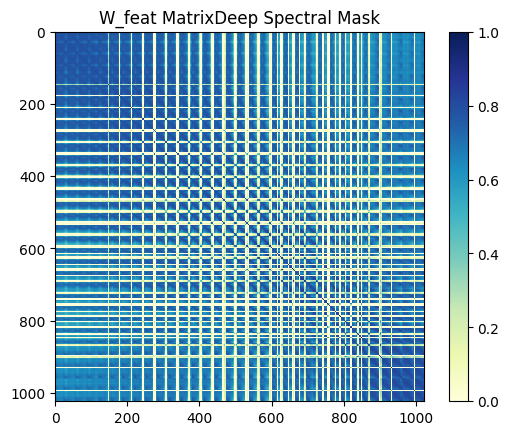

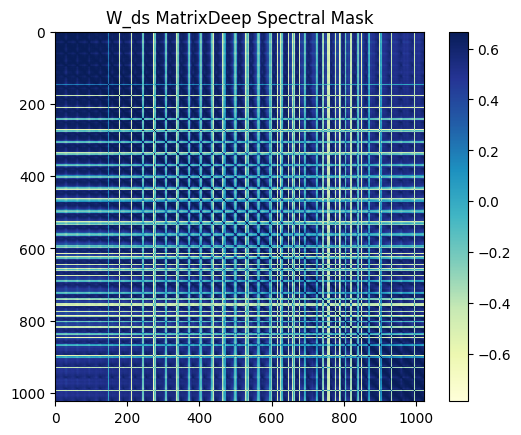

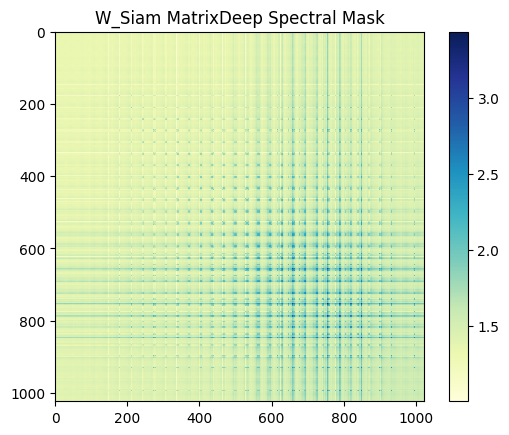

In [8]:
# numpy_array = W_feat_srgmask.numpy()
type='Deep Spectral Mask'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_srgmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_srgmask.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


import matplotlib.pyplot as plt
feat='W_ds Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_ds_srgmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_ds_srgmask.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()

import matplotlib.pyplot as plt


feat='W_Siam Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_siam_srgmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_siam_srgmask.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


## Ground Truth MAsk

In [9]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/ground_truth_mask"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/"
pca_comp=64
pca = PCA(n_components=pca_comp)
utils.make_output_dir(output_dir)
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))

features_file = features_dir + filename + '.pth'
print(features_file)
 # Load
data_dict = torch.load(features_file, map_location='cpu')
print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
# print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
image_id = data_dict['file'][:-4]
print(image_id)
# Load
output_file = str(Path(output_dir) / f'{image_id}.pth')
if Path(output_file).is_file():
    print(f'Skipping existing file {str(output_file)}')
    # break
    # return  # skip because already generated

# Load affinity matrix
feats = data_dict[which_features].squeeze().cuda()
print("Without normalizing, Features Shape outside laplacian is",feats.shape)
if normalize:
    feats = F.normalize(feats, p=2, dim=-1)
print("After normalization, Features Shape outside laplacian ",feats.shape)
# print("which_matrix=", which_matrix)
# Eigenvectors of affinity matrix
if which_matrix == 'affinity_torch':
    W = feats @ feats.T
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
        # print("W shape=", W.shape)
    eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
    eigenvalues = eigenvalues.cpu()
    eigenvectors = eigenvectors.cpu()
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity_svd':
    USV = torch.linalg.svd(feats, full_matrices=False)
    eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
    eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
    print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity':
    # print("Without normalizing, Features Shape is",feats.shape)
    W = (feats @ feats.T)
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
    W = W.cpu().numpy()
    # print("W shape=", W.shape)
    eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
    eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of matting laplacian matrix
elif which_matrix in ['matting_laplacian', 'laplacian']:

    # Get sizes
    B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
    if image_downsample_factor is None:
        image_downsample_factor = P
    H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

    # Upscale features to match the resolution
    if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
        feats = F.interpolate(
            feats.T.reshape(1, -1, H_patch, W_patch),
            size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
        ).reshape(-1, H_pad_lr * W_pad_lr).T

    ### Feature affinities
    print("Without normalizing, Features Shape insiade laplacian is",feats.shape)

    W_feat_ds_groundmask = (feats @ feats.T)
    print("shape of W_feat_ds_groundmask", W_feat_ds_groundmask.shape)
    max_wfeatds=torch.max(W_feat_ds_groundmask).item()
    alpha=3
    print("Before Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_groundmask, 0.))
    print("positive values=", count_positive)
    W_feat_ds_groundmask_sum = torch.sum(W_feat_ds_groundmask)
    print("W_feat_ds_groundmask_sum=", W_feat_ds_groundmask_sum)
    W_feat_ds_groundmask_mean = torch.mean(W_feat_ds_groundmask)
    print("Mean of W_feat_ds_groundmask", W_feat_ds_groundmask_mean)
    W_feat_ds_groundmask_median = torch.median(W_feat_ds_groundmask)
    print("Median of W_feat_ds_groundmask", W_feat_ds_groundmask_median)
    W_feat_ds_groundmask_std = torch.std(W_feat_ds_groundmask)
    print("Standard Deviation of W_feat_ds_groundmask", W_feat_ds_groundmask_std)
    W_feat_ds_groundmask_max = torch.max(W_feat_ds_groundmask)
    print("Maximum of W_feat_ds_groundmask", W_feat_ds_groundmask_max)
    W_feat_ds_groundmask_min = torch.min(W_feat_ds_groundmask)
    print("Minimum of W_feat_ds_groundmask", W_feat_ds_groundmask_min)
    print("Factor value", (max_wfeatds / alpha))

    W_feat_ds_groundmask = W_feat_ds_groundmask - (max_wfeatds / alpha)

    print("After Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_groundmask, 0.))
    print("positive values=", count_positive)
    W_feat_ds_groundmask_sum = torch.sum(W_feat_ds_groundmask)
    print("W_feat_ds_groundmask_sum=", W_feat_ds_groundmask_sum)
    W_feat_ds_groundmask_mean = torch.mean(W_feat_ds_groundmask)
    print("Mean of W_feat_ds_groundmask", W_feat_ds_groundmask_mean)
    W_feat_ds_groundmask_median = torch.median(W_feat_ds_groundmask)
    print("Median of W_feat_ds_groundmask", W_feat_ds_groundmask_median)
    W_feat_ds_groundmask_std = torch.std(W_feat_ds_groundmask)
    print("Standard Deviation of W_feat", W_feat_ds_groundmask_std)
    W_feat_ds_groundmask_max = torch.max(W_feat_ds_groundmask)
    print("Maximum of W_feat_ds_groundmask", W_feat_ds_groundmask_max)
    W_feat_ds_groundmask_min = torch.min(W_feat_ds_groundmask)
    print("Minimum of W_feat_ds_groundmask", W_feat_ds_groundmask_min)
    proj_layer=nn.Linear(pca_comp,pca_comp).cuda()
    pred_layer=nn.Linear(pca_comp,pca_comp).cuda()
    x0=feats
    x0_arr=x0.cpu()
    # print(x0_arr.shape)
    z0_arr= pca.fit_transform(x0_arr)

    # Define the affine transformation parameters
    scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
    translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
    rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
    shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions

    # Define the affine matrix
    affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
                              [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
                              [0, 0, 1]])
    z1_arr=affine_transform(z0_arr, affine_matrix)
#         z1_arr=pca.fit_transform(z1_arr)
    z0 = torch.from_numpy(z0_arr).float()
    z1 = torch.from_numpy(z1_arr).float()

    # feat_list.append(feats)
    feat_dataset_z0 = Feature_Dataset(z0)
    if feats.shape[0]%2==0:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)

    feat_dataset_z1 = Feature_Dataset(z1)
    if feats.shape[0]%2==0:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    criterion = NegativeCosineSimilarity()
    proj_optimizer = torch.optim.SGD(proj_layer.parameters(), lr=0.06)
    pred_optimizer = torch.optim.SGD(pred_layer.parameters(), lr=0.06)
    print("Starting Training")
    for epoch in range(epochs):
        total_loss = 0
        for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
            z0_new = z0_new.to(device)
            z1_new = z1_new.to(device)
            z0_new=proj_layer(z0_new)
            z1_new=proj_layer(z1_new)
#             print("z0_new.shape", z0_new.shape)
#             print("z1_new.shape", z1_new.shape)
            p0=pred_layer(z0_new)
            p1=pred_layer(z1_new)
#             print("p0.shape", p0.shape)
#             print("p1.shape", p1.shape)

            z0_new=z0_new.detach()
            z1_new=z1_new.detach()
            loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
            total_loss += loss.detach()
            loss.backward()
            proj_optimizer.step()
            pred_optimizer.step()
            proj_optimizer.zero_grad()
            pred_optimizer.zero_grad()
        avg_loss = total_loss / len(features_dataloader_z0)
        print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    # z0_projected=proj_layer(z0.to(device))
    projected_feature=pred_layer(z0.to(device))
    print(projected_feature.shape)
    W_feat_siam_groundmask=torch.matmul(projected_feature, projected_feature.t())
    # max_wfeatsiam=torch.max(W_feat_siam_groundmask).item()
    # alpha=3
    # W_feat_siam_groundmask = W_feat_siam_groundmask - (max_wfeatsiam / alpha)
    # W_feat_siam_groundmask=torch.matmul(projected_feature[0], projected_feature[0].t())
    W_feat_groundmask=W_feat_ds_groundmask + 0.1*W_feat_siam_groundmask
    print("W_feat_siam_groundmask.shape=", W_feat_siam_groundmask.shape)
    print("W_feat_ds_groundmask.shape=", W_feat_ds_groundmask.shape)
    print("W_feat_groundmask.shape=", W_feat_groundmask.shape)
    if threshold_at_zero:
        W_feat_groundmask = (W_feat_groundmask * (W_feat_groundmask > 0))
    W_feat_groundmask = W_feat_groundmask / W_feat_groundmask.max()  # NOTE: If features are normalized, this naturally does nothing
    # W_feat_groundmask = W_feat_groundmask.cpu().numpy()
    W_feat_groundmask = W_feat_groundmask.detach().cpu().numpy()
    W_feat_ds_groundmask = W_feat_ds_groundmask.detach().cpu().numpy()
    W_feat_siam_groundmask = W_feat_siam_groundmask.detach().cpu().numpy()
    # print("W_feat_groundmask shape=",W_feat_groundmask.shape)

    ### Color affinities
    # If we are fusing with color affinites, then load the image and compute
    W_color=0
    # Combine
    W_comb = W_feat_groundmask + W_color * image_color_lambda  # combination
    D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
    # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
    if lapnorm:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
    else:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
    eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
# Sign ambiguity
for k in range(eigenvectors.shape[0]):
    if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
        eigenvectors[k] = 0 - eigenvectors[k]

# Save dict
output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
torch.save(output_dict, output_file)

Output dir: /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new
/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/0079_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0079_resized
Skipping existing file /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new/0079_resized.pth
Without normalizing, Features Shape outside laplacian is torch.Size([1024, 384])
After normalization, Features Shape outside laplacian  torch.Size([1024, 384])
Without normalizing, Features Shape insiade laplacian is torch.Size([1024, 384])
shape of W_feat_ds_groundmask torch.Size([1024, 1024])
Before Subtraction
positive values= tensor(970358, device='cuda:0')
W_feat_ds_groundmask_sum= tensor(731290.5000, device='cuda:0')
Mean

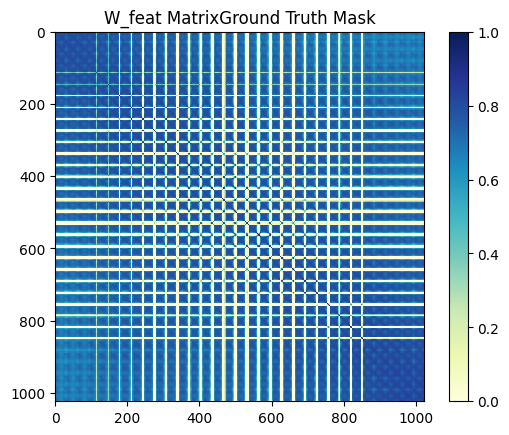

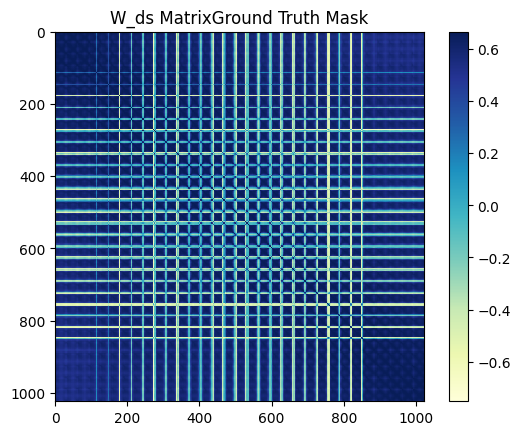

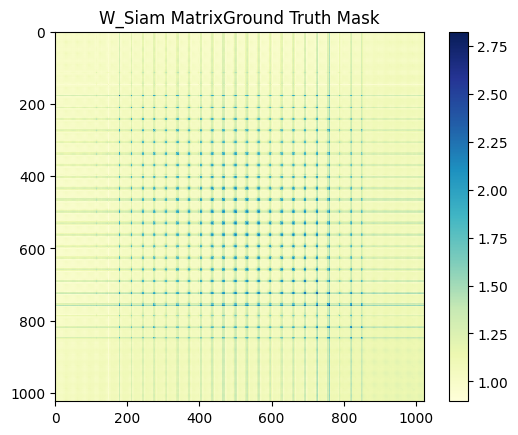

In [10]:

# numpy_array = W_feat_groundmask.numpy()
type='Ground Truth Mask'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_groundmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_groundmask.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


feat='W_ds Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_ds_groundmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_ds_groundmask.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


feat='W_Siam Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_siam_groundmask.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_siam_groundmask.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


## Computing Frobenius Norm between Masks

In [11]:
print(W_feat_oursmask.shape)
print(W_feat_groundmask.shape)
print(W_feat_srgmask.shape)

(1024, 1024)
(1024, 1024)
(1024, 1024)


In [12]:
# Calculate element-wise squared difference between the matrices
squared_diff = (W_feat_groundmask - W_feat_oursmask) ** 2

# Sum the squared differences
sum_squared_diff = np.sum(squared_diff)

# Take the square root to get the Frobenius norm
frobenius_norm = np.sqrt(sum_squared_diff)

print("Frobenius Norm between ground and ours mask affinity:", frobenius_norm.item())

Frobenius Norm between ground and ours mask affinity: 149.45172119140625


In [13]:
# Calculate element-wise squared difference between the matrices
squared_diff = (W_feat_groundmask - W_feat_srgmask) ** 2

# Sum the squared differences
sum_squared_diff = np.sum(squared_diff)

# Take the square root to get the Frobenius norm
frobenius_norm = np.sqrt(sum_squared_diff)

print("Frobenius Norm between ground and Deep Spectral mask affinity:", frobenius_norm.item())

Frobenius Norm between ground and Deep Spectral mask affinity: 205.5296630859375


## Input Images

In [14]:
images_root="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/images"
features_dir="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/"
pca_comp=64
pca = PCA(n_components=pca_comp)
utils.make_output_dir(output_dir)
inputs = list(enumerate(sorted(Path(features_dir).iterdir())))

features_file = features_dir + filename +'.pth'
print(features_file)
 # Load
data_dict = torch.load(features_file, map_location='cpu')
print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
# print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
image_id = data_dict['file'][:-4]
print(image_id)
# Load
output_file = str(Path(output_dir) / f'{image_id}.pth')
if Path(output_file).is_file():
    print(f'Skipping existing file {str(output_file)}')
    # break
    # return  # skip because already generated

# Load affinity matrix
feats = data_dict[which_features].squeeze().cuda()
print("Without normalizing, Features Shape outside laplacian is",feats.shape)
if normalize:
    feats = F.normalize(feats, p=2, dim=-1)
print("After normalization, Features Shape outside laplacian ",feats.shape)
# print("which_matrix=", which_matrix)
# Eigenvectors of affinity matrix
if which_matrix == 'affinity_torch':
    W = feats @ feats.T
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
        # print("W shape=", W.shape)
    eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
    eigenvalues = eigenvalues.cpu()
    eigenvectors = eigenvectors.cpu()
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)


# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity_svd':
    USV = torch.linalg.svd(feats, full_matrices=False)
    eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
    eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
    print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of affinity matrix with scipy
elif which_matrix == 'affinity':
    # print("Without normalizing, Features Shape is",feats.shape)
    W = (feats @ feats.T)
    # W_feat=contrastive_affinity(feats, feats.T)
    # print("W shape=", W.shape)
    if threshold_at_zero:
        W = (W * (W > 0))
    W = W.cpu().numpy()
    # print("W shape=", W.shape)
    eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
    eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
    print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)

# Eigenvectors of matting laplacian matrix
elif which_matrix in ['matting_laplacian', 'laplacian']:

    # Get sizes
    B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
    if image_downsample_factor is None:
        image_downsample_factor = P
    H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor

    # Upscale features to match the resolution
    if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
        feats = F.interpolate(
            feats.T.reshape(1, -1, H_patch, W_patch),
            size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
        ).reshape(-1, H_pad_lr * W_pad_lr).T

    ### Feature affinities
    print("Without normalizing, Features Shape insiade laplacian is",feats.shape)

    W_feat_ds_inputimage = (feats @ feats.T)
    print("shape of W_feat_ds_inputimage", W_feat_ds_inputimage.shape)
    max_wfeatds=torch.max(W_feat_ds_inputimage).item()
    alpha=3
    print("Before Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_inputimage, 0.))
    print("positive values=", count_positive)
    W_feat_ds_inputimage_sum = torch.sum(W_feat_ds_inputimage)
    print("W_feat_ds_inputimage_sum=", W_feat_ds_inputimage_sum)
    W_feat_ds_inputimage_mean = torch.mean(W_feat_ds_inputimage)
    print("Mean of W_feat_ds_inputimage", W_feat_ds_inputimage_mean)
    W_feat_ds_inputimage_median = torch.median(W_feat_ds_inputimage)
    print("Median of W_feat_ds_inputimage", W_feat_ds_inputimage_median)
    W_feat_ds_inputimage_std = torch.std(W_feat_ds_inputimage)
    print("Standard Deviation of W_feat_ds_inputimage", W_feat_ds_inputimage_std)
    W_feat_ds_inputimage_max = torch.max(W_feat_ds_inputimage)
    print("Maximum of W_feat_ds_inputimage", W_feat_ds_inputimage_max)
    W_feat_ds_inputimage_min = torch.min(W_feat_ds_inputimage)
    print("Minimum of W_feat_ds_inputimage", W_feat_ds_inputimage_min)
    print("Factor value", (max_wfeatds / alpha))

    W_feat_ds_inputimage = W_feat_ds_inputimage - (max_wfeatds / alpha)

    print("After Subtraction")
    count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds_inputimage, 0.))
    print("positive values=", count_positive)
    W_feat_ds_inputimage_sum = torch.sum(W_feat_ds_inputimage)
    print("W_feat_ds_inputimage_sum=", W_feat_ds_inputimage_sum)
    W_feat_ds_inputimage_mean = torch.mean(W_feat_ds_inputimage)
    print("Mean of W_feat_ds_inputimage", W_feat_ds_inputimage_mean)
    W_feat_ds_inputimage_median = torch.median(W_feat_ds_inputimage)
    print("Median of W_feat_ds_inputimage", W_feat_ds_inputimage_median)
    W_feat_ds_inputimage_std = torch.std(W_feat_ds_inputimage)
    print("Standard Deviation of W_feat", W_feat_ds_inputimage_std)
    W_feat_ds_inputimage_max = torch.max(W_feat_ds_inputimage)
    print("Maximum of W_feat_ds_inputimage", W_feat_ds_inputimage_max)
    W_feat_ds_inputimage_min = torch.min(W_feat_ds_inputimage)
    print("Minimum of W_feat_ds_inputimage", W_feat_ds_inputimage_min)
    proj_layer=nn.Linear(pca_comp,pca_comp).cuda()
    pred_layer=nn.Linear(pca_comp,pca_comp).cuda()
    x0=feats
    x0_arr=x0.cpu()
    # print(x0_arr.shape)
    z0_arr= pca.fit_transform(x0_arr)

    # Define the affine transformation parameters
    scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
    translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
    rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
    shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions

    # Define the affine matrix
    affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
                              [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
                              [0, 0, 1]])
    z1_arr=affine_transform(z0_arr, affine_matrix)
#         z1_arr=pca.fit_transform(z1_arr)
    z0 = torch.from_numpy(z0_arr).float()
    z1 = torch.from_numpy(z1_arr).float()

    # feat_list.append(feats)
    feat_dataset_z0 = Feature_Dataset(z0)
    if feats.shape[0]%2==0:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)

    feat_dataset_z1 = Feature_Dataset(z1)
    if feats.shape[0]%2==0:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
    else:
        features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    criterion = NegativeCosineSimilarity()
    proj_optimizer = torch.optim.SGD(proj_layer.parameters(), lr=0.06)
    pred_optimizer = torch.optim.SGD(pred_layer.parameters(), lr=0.06)
    print("Starting Training")
    for epoch in range(epochs):
        total_loss = 0
        for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
            z0_new = z0_new.to(device)
            z1_new = z1_new.to(device)
            z0_new=proj_layer(z0_new)
            z1_new=proj_layer(z1_new)
#             print("z0_new.shape", z0_new.shape)
#             print("z1_new.shape", z1_new.shape)
            p0=pred_layer(z0_new)
            p1=pred_layer(z1_new)
#             print("p0.shape", p0.shape)
#             print("p1.shape", p1.shape)

            z0_new=z0_new.detach()
            z1_new=z1_new.detach()
            loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
            total_loss += loss.detach()
            loss.backward()
            proj_optimizer.step()
            pred_optimizer.step()
            proj_optimizer.zero_grad()
            pred_optimizer.zero_grad()
        avg_loss = total_loss / len(features_dataloader_z0)
        print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    # z0_projected=proj_layer(z0.to(device))
    projected_feature=pred_layer(z0.to(device))
    print(projected_feature.shape)
    W_feat_siam_inputimage=torch.matmul(projected_feature, projected_feature.t())
    # max_wfeatsiam=torch.max(W_feat_siam_inputimage).item()
    # alpha=3
    # W_feat_siam_inputimage = W_feat_siam_inputimage - (max_wfeatsiam / alpha)
    # W_feat_siam_inputimage=torch.matmul(projected_feature[0], projected_feature[0].t())
    W_feat_inputimage=W_feat_ds_inputimage + 0.1*W_feat_siam_inputimage
    print("W_feat_siam_inputimage.shape=", W_feat_siam_inputimage.shape)
    print("W_feat_ds_inputimage.shape=", W_feat_ds_inputimage.shape)
    print("W_feat_inputimage.shape=", W_feat_inputimage.shape)
    if threshold_at_zero:
        W_feat_inputimage = (W_feat_inputimage * (W_feat_inputimage > 0))
    W_feat_inputimage = W_feat_inputimage / W_feat_inputimage.max()  # NOTE: If features are normalized, this naturally does nothing
    # W_feat_inputimage = W_feat_inputimage.cpu().numpy()
    W_feat_inputimage = W_feat_inputimage.detach().cpu().numpy()
    W_feat_ds_inputimage = W_feat_ds_inputimage.detach().cpu().numpy()
    W_feat_siam_inputimage = W_feat_siam_inputimage.detach().cpu().numpy()
    # print("W_feat_inputimage shape=",W_feat_inputimage.shape)

    ### Color affinities
    # If we are fusing with color affinites, then load the image and compute
    W_color=0
    # Combine
    W_comb = W_feat_inputimage + W_color * image_color_lambda  # combination
    D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
    # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
    if lapnorm:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
    else:
        try:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
        except:
            eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
    eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
# Sign ambiguity
for k in range(eigenvectors.shape[0]):
    if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
        eigenvectors[k] = 0 - eigenvectors[k]

# Save dict
output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
torch.save(output_dict, output_file)

Output dir: /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new
/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features/0079_resized.pth
dict_keys(['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape'])
0079_resized
Skipping existing file /home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/eigs_dot1PCA64linearpredlinear_dssubmax_pred2_plotfeature_new/0079_resized.pth
Without normalizing, Features Shape outside laplacian is torch.Size([1024, 384])
After normalization, Features Shape outside laplacian  torch.Size([1024, 384])
Without normalizing, Features Shape insiade laplacian is torch.Size([1024, 384])
shape of W_feat_ds_inputimage torch.Size([1024, 1024])
Before Subtraction
positive values= tensor(801864, device='cuda:0')
W_feat_ds_inputimage_sum= tensor(354054.7500, device='cuda:0')
Mean of W

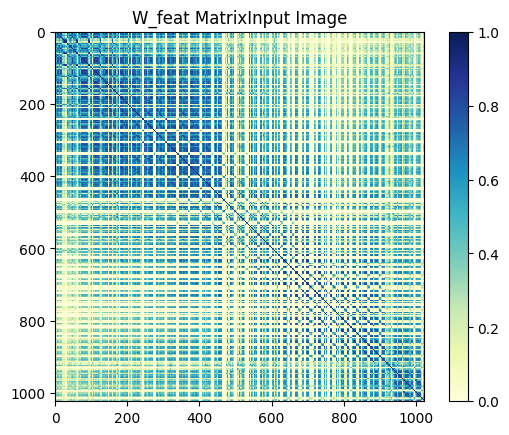

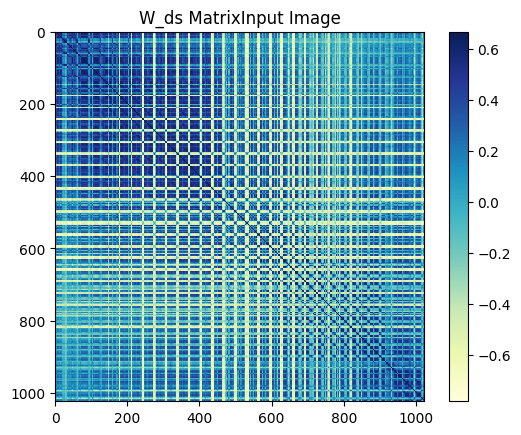

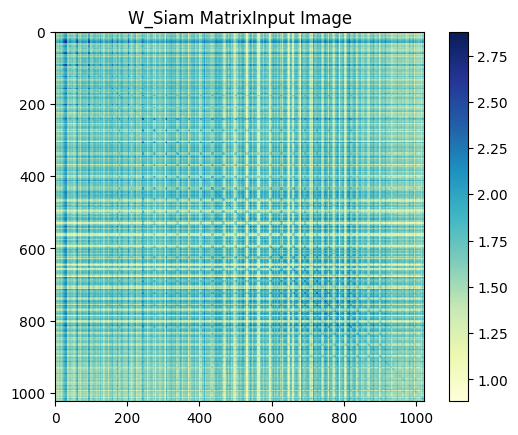

In [15]:
# numpy_array = W_feat_inputimage.numpy()
type='Input Image'
feat='W_feat Matrix'

# Downsample the tensor by averaging values in small blocks
downsampled_array = np.mean(W_feat_inputimage.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_inputimage.reshape(32,32,32,32), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


feat='W_ds Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_ds_inputimage.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_ds_inputimage.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


feat='W_Siam Matrix'
# Downsample the tensor by averaging values in small blocks

downsampled_array = np.mean(W_feat_siam_inputimage.reshape(1024, 1, 1024, 1), axis=(1, 3))
# downsampled_array = np.mean(W_feat_siam_inputimage.reshape(64, 16, 64, 16), axis=(1, 3))

# Plot the heatmap of the downsampled tensor
plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
plt.colorbar()
plt.title( feat + type)
plt.savefig('/home/phdcs2/Downloads/' + filename + feat + type )
plt.show()


## Computing Frobenius Norm between DS and SSiamDSM affinity wrt Ground Truth Affinity

In [16]:
print(W_feat_inputimage.shape)
print(W_feat_groundmask.shape)
print(W_feat_ds_inputimage.shape)

(1024, 1024)
(1024, 1024)
(1024, 1024)


In [17]:
# Calculate element-wise squared difference between the matrices
squared_diff = (W_feat_groundmask - W_feat_inputimage) ** 2

# Sum the squared differences
sum_squared_diff = np.sum(squared_diff)

# Take the square root to get the Frobenius norm
frobenius_norm = np.sqrt(sum_squared_diff)

print("Frobenius Norm between ground mask and ours affinity on image:", frobenius_norm.item())

Frobenius Norm between ground mask and ours affinity on image: 374.174560546875


In [18]:

# Calculate element-wise squared difference between the matrices
squared_diff = (W_feat_groundmask - W_feat_ds_inputimage) ** 2

# Sum the squared differences
sum_squared_diff = np.sum(squared_diff)

# Take the square root to get the Frobenius norm
frobenius_norm = np.sqrt(sum_squared_diff)

print("Frobenius Norm between ground mask and Deep Spectral affinity on image:", frobenius_norm.item())

Frobenius Norm between ground mask and Deep Spectral affinity on image: 591.327392578125


## Original Working code for producing Eigen Vectors

In [19]:

# # Load image
# dir='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/images/'
# image_id=filename
# image_file = str(Path(dir) / f'{image_id}.png')
# features_file='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/feats_vis_feature_affinity/' + filenmae + '.pth'
# print("image file=", image_file)
# print("Feature File", features_file)
# image_downsample_factor=None
# # inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
# # for inp in tqdm(inputs[123:124]):
# # index, features_file = tqdm(inputs[123:124])
# # data_dict = torch.load(features_file, map_location='cpu')
# # B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
# # if image_downsample_factor is None:
# #     image_downsample_factor = P
# # H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor
# # image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#
# ##Addedd by chanda for blurring
# image = Image.open(image_file)
# img = asarray(image)
#
#
# #Averaing filter
# kernel = np.ones((15,15),np.float32)/25
# dst = cv.filter2D(img,-1,kernel)
#
# #uniform Blur
# ublur = cv.blur(img,(15,15))
#
# #Bilateral Filtering
# bblur = cv.bilateralFilter(img,15,75,75)
#
# #Median Blur
# median = cv.medianBlur(img,15)
#
# #Gaussina Blur
# gblur = cv.GaussianBlur(img,(15,15),0)
#
# image= Image.fromarray(gblur)
#
# image_lr = image.resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#
# ##Ended by Chanda for Blurring
#
# name_blur='GaussianBlur_inputimage'
# image_lr = np.array(image_lr) / 255.
#
# # Color affinities (of type scipy.sparse.csr_matrix)
# if which_color_matrix == 'knn':
#     W_lr = utils.knn_affinity(image_lr / 255)
# elif which_color_matrix == 'rw':
#     W_lr = utils.rw_affinity(image_lr / 255)
#
# # Convert to dense numpy array
# W_color = np.array(W_lr.todense().astype(np.float32))
# # print("W_color shape", W_color.shape)
# import matplotlib.pyplot as plt
# # numpy_array = W_feat.numpy()
# feat='W_color Matrix'
# # Downsample the tensor by averaging values in small blocks
# downsampled_array = np.mean(W_color.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title( feat + ' 1.0 ' + name_blur)
# plt.savefig('/home/phdcs2/Downloads/' +feat+ name_blur)
# plt.show()


In [20]:
# # Load image
# # dir='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/ground_truth_mask/'
# # dir='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/srg/crf/laplacian_dino_vits16'
# dir='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/srg_dot1PCA64linearpredlinear_dssubmax_pred2_run3/crf/laplacian_dino_vits16'
# image_id=filename
# image_file = str(Path(dir) / f'{image_id}.png')
# # features_file='/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/mask_features/' + filename + '.pth'
# # features_file="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_srg/" + filename + '.pth'
# features_file="/home/phdcs2/Hard_Disk/Datasets/Deep-Spectral-Segmentation/data/object-segmentation/ECSSD/features_ours/" + filenmae + ".pth"
# print("image file=", image_file)
# print("Feature File", features_file)
# # image_downsample_factor=None
# # data_dict = torch.load(features_file, map_location='cpu')
# # B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
# # if image_downsample_factor is None:
# #     image_downsample_factor = P
# # H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor
# # image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#
#
#
# ##Addedd by chanda for blurring
# image = Image.open(image_file)
# img_gray = asarray(image)
# img = cv.cvtColor(img_gray,cv.COLOR_GRAY2RGB)
#
# #Averaing filter
# kernel = np.ones((15,15),np.float32)/25
# dst = cv.filter2D(img,-1,kernel)
#
# #uniform Blur
# ublur = cv.blur(img,(15,15))
#
# #Bilateral Filtering
# bblur = cv.bilateralFilter(img,15,75,75)
#
# #Median Blur
# median = cv.medianBlur(img,15)
#
# #Gaussina Blur
# gblur = cv.GaussianBlur(img,(15,15),0)
#
# image= Image.fromarray(gblur)
#
# image_lr = image.resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#
# ##Ended by Chanda for Blurring
#
# name_blur='GaussianBlur_Mask'
# image_lr = np.array(image_lr) / 255.
#
# # Color affinities (of type scipy.sparse.csr_matrix)
# if which_color_matrix == 'knn':
#     W_lr = utils.knn_affinity(image_lr / 255)
# elif which_color_matrix == 'rw':
#     W_lr = utils.rw_affinity(image_lr / 255)
#
# # Convert to dense numpy array
# W_color = np.array(W_lr.todense().astype(np.float32))
# # print("W_color shape", W_color.shape)
# import matplotlib.pyplot as plt
# # numpy_array = W_feat.numpy()
# feat='W_color Matrix DeepSpectral'
# # Downsample the tensor by averaging values in small blocks
# downsampled_array = np.mean(W_color.reshape(1024, 1, 1024, 1), axis=(1, 3))
# # downsampled_array = np.mean(W_feat.reshape(64, 16, 64, 16), axis=(1, 3))
#
# # Plot the heatmap of the downsampled tensor
# plt.imshow(downsampled_array, cmap='YlGnBu', interpolation='nearest')
# plt.colorbar()
# plt.title(feat+ '1.0 ' + name_blur)
# plt.savefig('/home/phdcs2/Downloads/' + feat + name_blur)
# plt.show()
#
#
#


In [21]:
# pca_comp=64
# pca = PCA(n_components=pca_comp)
# utils.make_output_dir(output_dir)
# inputs = list(enumerate(sorted(Path(features_dir).iterdir())))
# for inp in tqdm(inputs[123:124]):
#     index, features_file = inp
#     print(index, features_file)
#      # Load
#     data_dict = torch.load(features_file, map_location='cpu')
#     print(data_dict.keys())   #['k', 'indices', 'file', 'id', 'model_name', 'patch_size', 'shape']
#     # print("shape=", data_dict['shape'], "k shape", data_dict['k'].shape, "patch_size=", data_dict['patch_size'])
#     image_id = data_dict['file'][:-4]
#     print(image_id)
#     # Load
#     output_file = str(Path(output_dir) / f'{image_id}.pth')
#     if Path(output_file).is_file():
#         print(f'Skipping existing file {str(output_file)}')
#         # break
#         # return  # skip because already generated
#
#     # Load affinity matrix
#     feats = data_dict[which_features].squeeze().cuda()
#     print("Without normalizing, Features Shape outside laplacian is",feats.shape)
#     if normalize:
#         feats = F.normalize(feats, p=2, dim=-1)
#     print("After normalization, Features Shape outside laplacian ",feats.shape)
#     # print("which_matrix=", which_matrix)
#     # Eigenvectors of affinity matrix
#     if which_matrix == 'affinity_torch':
#         W = feats @ feats.T
#         # W_feat=contrastive_affinity(feats, feats.T)
#         # print("W shape=", W.shape)
#         if threshold_at_zero:
#             W = (W * (W > 0))
#             # print("W shape=", W.shape)
#         eigenvalues, eigenvectors = torch.eig(W, eigenvectors=True)
#         eigenvalues = eigenvalues.cpu()
#         eigenvectors = eigenvectors.cpu()
#         print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#
#     # Eigenvectors of affinity matrix with scipy
#     elif which_matrix == 'affinity_svd':
#         USV = torch.linalg.svd(feats, full_matrices=False)
#         eigenvectors = USV[0][:, :K].T.to('cpu', non_blocking=True)
#         eigenvalues = USV[1][:K].to('cpu', non_blocking=True)
#         print("which matrix=",which_matrix,"eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#     # Eigenvectors of affinity matrix with scipy
#     elif which_matrix == 'affinity':
#         # print("Without normalizing, Features Shape is",feats.shape)
#         W = (feats @ feats.T)
#         # W_feat=contrastive_affinity(feats, feats.T)
#         # print("W shape=", W.shape)
#         if threshold_at_zero:
#             W = (W * (W > 0))
#         W = W.cpu().numpy()
#         # print("W shape=", W.shape)
#         eigenvalues, eigenvectors = eigsh(W, which='LM', k=K)
#         eigenvectors = torch.flip(torch.from_numpy(eigenvectors), dims=(-1,)).T
#         print("which matrix=",which_matrix, "eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#
#     # Eigenvectors of matting laplacian matrix
#     elif which_matrix in ['matting_laplacian', 'laplacian']:
#
#         # Get sizes
#         B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = utils.get_image_sizes(data_dict)
#         if image_downsample_factor is None:
#             image_downsample_factor = P
#         H_pad_lr, W_pad_lr = H_pad // image_downsample_factor, W_pad // image_downsample_factor
#
#         # Upscale features to match the resolution
#         if (H_patch, W_patch) != (H_pad_lr, W_pad_lr):
#             feats = F.interpolate(
#                 feats.T.reshape(1, -1, H_patch, W_patch),
#                 size=(H_pad_lr, W_pad_lr), mode='bilinear', align_corners=False
#             ).reshape(-1, H_pad_lr * W_pad_lr).T
#
#         ### Feature affinities
#         print("Without normalizing, Features Shape insiade laplacian is",feats.shape)
#
#         W_feat_ds = (feats @ feats.T)
#         print("shape of w_feat_ds", W_feat_ds.shape)
#         max_wfeatds=torch.max(W_feat_ds).item()
#         alpha=3
#         print("Before Subtraction")
#         count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds, 0.))
#         print("positive values=", count_positive)
#         W_feat_ds_sum = torch.sum(W_feat_ds)
#         print("w_feat_ds_sum=", W_feat_ds_sum)
#         W_feat_ds_mean = torch.mean(W_feat_ds)
#         print("Mean of W_feat", W_feat_ds_mean)
#         W_feat_ds_median = torch.median(W_feat_ds)
#         print("Median of W_feat", W_feat_ds_median)
#         W_feat_ds_std = torch.std(W_feat_ds)
#         print("Standard Deviation of W_feat", W_feat_ds_std)
#         W_feat_ds_max = torch.max(W_feat_ds)
#         print("Maximum of W_feat", W_feat_ds_max)
#         W_feat_ds_min = torch.min(W_feat_ds)
#         print("Minimum of W_feat", W_feat_ds_min)
#         print("Factor value", (max_wfeatds / alpha))
#
#         W_feat_ds = W_feat_ds - (max_wfeatds / alpha)
#
#         print("After Subtraction")
#         count_positive = torch.count_nonzero(torch.greater_equal(W_feat_ds, 0.))
#         print("positive values=", count_positive)
#         W_feat_ds_sum = torch.sum(W_feat_ds)
#         print("w_feat_ds_sum=", W_feat_ds_sum)
#         W_feat_ds_mean = torch.mean(W_feat_ds)
#         print("Mean of W_feat", W_feat_ds_mean)
#         W_feat_ds_median = torch.median(W_feat_ds)
#         print("Median of W_feat", W_feat_ds_median)
#         W_feat_ds_std = torch.std(W_feat_ds)
#         print("Standard Deviation of W_feat", W_feat_ds_std)
#         W_feat_ds_max = torch.max(W_feat_ds)
#         print("Maximum of W_feat", W_feat_ds_max)
#         W_feat_ds_min = torch.min(W_feat_ds)
#         print("Minimum of W_feat", W_feat_ds_min)
#         proj_layer=nn.Linear(pca_comp,pca_comp).cuda()
#         pred_layer=nn.Linear(pca_comp,pca_comp).cuda()
#         x0=feats
#         x0_arr=x0.cpu()
#         # print(x0_arr.shape)
#         z0_arr= pca.fit_transform(x0_arr)
#
#         # Define the affine transformation parameters
#         scale = np.random.uniform(0.8, 1.2)  # Random scaling factor between 0.8 and 1.2
#         translation = np.random.uniform(-10, 10, size=2)  # Random translation vector between -10 and 10 in both directions
#         rotation = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
#         shear = np.random.uniform(-0.2, 0.2, size=2)  # Random shear factor between -0.2 and 0.2 in both directions
#
#         # Define the affine matrix
#         affine_matrix = np.array([[scale * np.cos(rotation), -shear[0] * scale * np.sin(rotation), translation[0]],
#                                   [shear[1] * scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
#                                   [0, 0, 1]])
#         z1_arr=affine_transform(z0_arr, affine_matrix)
# #         z1_arr=pca.fit_transform(z1_arr)
#         z0 = torch.from_numpy(z0_arr).float()
#         z1 = torch.from_numpy(z1_arr).float()
#
#         # feat_list.append(feats)
#         feat_dataset_z0 = Feature_Dataset(z0)
#         if feats.shape[0]%2==0:
#             features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True)
#         else:
#             features_dataloader_z0 = DataLoader(feat_dataset_z0, batch_size=batch_size, shuffle=True, drop_last=True)
#
#         feat_dataset_z1 = Feature_Dataset(z1)
#         if feats.shape[0]%2==0:
#             features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True)
#         else:
#             features_dataloader_z1 = DataLoader(feat_dataset_z1, batch_size=batch_size, shuffle=True, drop_last=True)
#         device = "cuda" if torch.cuda.is_available() else "cpu"
#
#         criterion = NegativeCosineSimilarity()
#         proj_optimizer = torch.optim.SGD(proj_layer.parameters(), lr=0.06)
#         pred_optimizer = torch.optim.SGD(pred_layer.parameters(), lr=0.06)
#         print("Starting Training")
#         for epoch in range(epochs):
#             total_loss = 0
#             for z0_new,z1_new in zip(features_dataloader_z0,features_dataloader_z1):
#                 z0_new = z0_new.to(device)
#                 z1_new = z1_new.to(device)
#                 z0_new=proj_layer(z0_new)
#                 z1_new=proj_layer(z1_new)
#     #             print("z0_new.shape", z0_new.shape)
#     #             print("z1_new.shape", z1_new.shape)
#                 p0=pred_layer(z0_new)
#                 p1=pred_layer(z1_new)
#     #             print("p0.shape", p0.shape)
#     #             print("p1.shape", p1.shape)
#
#                 z0_new=z0_new.detach()
#                 z1_new=z1_new.detach()
#                 loss = 0.5 * (criterion(z0_new, p1) + criterion(z1_new, p0))
#                 total_loss += loss.detach()
#                 loss.backward()
#                 proj_optimizer.step()
#                 pred_optimizer.step()
#                 proj_optimizer.zero_grad()
#                 pred_optimizer.zero_grad()
#             avg_loss = total_loss / len(features_dataloader_z0)
#             print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
#         # z0_projected=proj_layer(z0.to(device))
#         projected_feature=pred_layer(z0.to(device))
#         print(projected_feature.shape)
#         W_feat_siam=torch.matmul(projected_feature, projected_feature.t())
#         # max_wfeatsiam=torch.max(W_feat_siam).item()
#         # alpha=3
#         # W_feat_siam = W_feat_siam - (max_wfeatsiam / alpha)
#         # W_feat_siam=torch.matmul(projected_feature[0], projected_feature[0].t())
#         W_feat=W_feat_ds + 0.1*W_feat_siam
#         print("W_feat_siam.shape=", W_feat_siam.shape)
#         print("W_feat_ds.shape=", W_feat_ds.shape)
#         print("W_feat.shape=", W_feat.shape)
# #         W_feat=normalize_affinity_matrix(W_feat_unnorm, axis=1)
#         # print("W_feat.shape=", W_feat.shape)
#         # print("W_feat.shape=", W_feat.shape)
#         # W_feat=contrastive_affinity(feats, feats.T)
#         if threshold_at_zero:
#             W_feat = (W_feat * (W_feat > 0))
#         W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
#         # W_feat = W_feat.cpu().numpy()
#         W_feat = W_feat.detach().cpu().numpy()
#         # print("W_feat shape=",W_feat.shape)
#
#         ### Color affinities
#         # If we are fusing with color affinites, then load the image and compute
#         if image_color_lambda > 0:
#
#             # Load image
#             image_file = str(Path(images_root) / f'{image_id}.png')
#             # image_lr = Image.open(image_file).resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#
#             ##Addedd by chanda for blurring
#             image = Image.open(image_file)
#             img = asarray(image)
#
#             #Averaing filter
#             kernel = np.ones((5,5),np.float32)/25
#             dst = cv.filter2D(img,-1,kernel)
#
#             #Bilateral Filtering
#             bblur = cv.bilateralFilter(img,7,75,75)
#
#             #Median Blur
#             median = cv.medianBlur(img,5)
#
#             #Gaussina Blur
#             gblur = cv.GaussianBlur(img,(5,5),0)
#
#             image= Image.fromarray(gblur)
#
#             image_lr = image.resize((W_pad_lr, H_pad_lr), Image.BILINEAR)
#             ##Ended by Chanda for Blurring
#
#             image_lr = np.array(image_lr) / 255.
#
#             # Color affinities (of type scipy.sparse.csr_matrix)
#             if which_color_matrix == 'knn':
#                 W_lr = utils.knn_affinity(image_lr / 255)
#             elif which_color_matrix == 'rw':
#                 W_lr = utils.rw_affinity(image_lr / 255)
#
#             # Convert to dense numpy array
#             W_color = np.array(W_lr.todense().astype(np.float32))
#             # print("W_color shape", W_color.shape)
#
#         else:
#
#             # No color affinity
#             W_color = 0
#
#         # Combine
#         W_comb = W_feat + W_color * image_color_lambda  # combination
#         D_comb = np.array(utils.get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check
#         # print("W_comb shape= ", W_comb.shape, "D_comb shape",  D_comb.shape)
#         if lapnorm:
#             try:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM', M=D_comb)
#             except:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM', M=D_comb)
#         else:
#             try:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, sigma=0, which='LM')
#             except:
#                 eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=K, which='SM')
#         eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()
#     print("eigenvalues shape", eigenvalues.shape, "eigenvectors shape", eigenvectors.shape)
#     # Sign ambiguity
#     for k in range(eigenvectors.shape[0]):
#         if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
#             eigenvectors[k] = 0 - eigenvectors[k]
#
#     # Save dict
#     output_dict = {'eigenvalues': eigenvalues, 'eigenvectors': eigenvectors}
#     torch.save(output_dict, output_file)